### Imports

In [ ]:
# install requirements
!pip install pretrainedmodels==0.7.4
!pip install segmentation_models_pytorch
!pip install -U git+https://github.com/albu/albumentations

  Cloning https://github.com/albu/albumentations to /tmp/pip-req-build-wyqehxwx
  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-wyqehxwx
  Created wheel for albumentations: filename=albumentations-0.4.5-cp36-none-any.whl size=65038 sha256=5a495df0dfe2468615b985423af7b3659f5bfe3d05abc3f24ccc9bc360d3e765
  Stored in directory: /tmp/pip-ephem-wheel-cache-slc8juw7/wheels/45/8b/e4/2837bbcf517d00732b8e394f8646f22b8723ac00993230188b
Successfully built albumentations
  Found existing installation: albumentations 0.4.5
    Uninstalling albumentations-0.4.5:
      Successfully uninstalled albumentations-0.4.5


In [ ]:
import os
import random
import zipfile
import shutil
import segmentation_models_pytorch as smp
import numpy as np
import matplotlib.pyplot as plt
import PIL
import cv2
import albumentations as albu
import torch
import torch.nn as nn
from PIL import Image, ImageDraw
from albumentations.pytorch import ToTensor
from segmentation_models_pytorch.encoders import get_preprocessing_fn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

#Prepare data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Распаковка датасета
with zipfile.ZipFile('/content/drive/My Drive/dataFull.zip', 'r') as zip_ref:
  zip_ref.extractall('/content/')

In [ ]:
# create common folder for dataset
!mkdir /content/dataset/
!mkdir /content/dataset/train
!mkdir /content/dataset/val
!mkdir /content/dataset/test
!mkdir /content/dataset/train/images
!mkdir /content/dataset/val/images
!mkdir /content/dataset/test/images
!mkdir /content/dataset/train/masks
!mkdir /content/dataset/val/masks
!mkdir /content/dataset/test/masks

In [ ]:
# folder list
list_folders = ['dataFull']

# cycle by folders
for folder in list_folders:
  list_images = os.listdir(os.path.join('/content/content/', folder, 'img'))
  random.shuffle(list_images)
  length = len(list_images)
  train = list_images[:int(0.8 * length)]
  val   = list_images[int(0.8 * length):int(0.9 * length)]
  test  = list_images[int(0.9 * length):]  
  for im in train:
    shutil.copyfile(os.path.join('/content/content/', folder, 'img', im), os.path.join('/content/dataset/train/images', folder+im))
    shutil.copyfile(os.path.join('/content/content/', folder, 'masks', im[:-3] +'png'), os.path.join('/content/dataset/train/masks', folder+im[:-3] +'png'))
  for im in val:
    shutil.copyfile(os.path.join('/content/content/', folder, 'img', im), os.path.join('/content/dataset/val/images', folder+im))
    shutil.copyfile(os.path.join('/content/content/', folder, 'masks', im[:-3] +'png'), os.path.join('/content/dataset/val/masks', folder+im[:-3] +'png'))
  for im in test:
    shutil.copyfile(os.path.join('/content/content/', folder, 'img', im), os.path.join('/content/dataset/test/images', folder+im))
    shutil.copyfile(os.path.join('/content/content/', folder, 'masks', im[:-3] +'png'), os.path.join('/content/dataset/test/masks', folder+im[:-3] +'png'))

### Define the model

In [ ]:
def get_training_augmentation():
  train_transform = [
      albu.Resize(256, 256),
      albu.HorizontalFlip(p=0.5),
      albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=0, shift_limit=0.03, p=0.5, border_mode=0),
      albu.Normalize(),
  ]
  return albu.Compose(train_transform)


def get_validation_augmentation():
    test_transform = [
          albu.Resize(256, 256),
          albu.Normalize()
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    print(x.shape)
    return x.transpose(2, 0, 1).astype('float32') #2 количество канаов
    # return x


def get_preprocessing(preprocessing_fn):
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [ ]:
colors = {"lips": "#FFFFFF", "eyes": "#B8E986", "nose": "#6EE061", "cheeks": "#5091E7", "chin": "#D17BC2",
          "Underlips": "#F8E71C", "eyebrows":  "#6BEBE6", "forehead": "#9B9B9B", "eyebrow": "#6BEBE6", "eye": "#B8E986"}
class Dataset(BaseDataset):
  def __init__(self, images_dir, masks_dir, 
               augmentation=None, preprocessing=None,):
      
    self.names = os.listdir(images_dir)
    self.images_paths = [os.path.join(images_dir, name) for name in self.names]
    self.masks_paths = [os.path.join(masks_dir, name[:-3]+'png') for name in self.names]
    self.augmentation = augmentation
    self.preprocessing = preprocessing
    self.class_values = set(colors.values())
    self.class_values = [tuple(int(color.lstrip('#')[i:i+2], 16) for i in (0, 2, 4)) for color in self.class_values]
    # print(self.class_values)
  def __getitem__(self, i):
      # read data
      image = cv2.imread(self.images_paths[i])
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      mask = cv2.imread(self.masks_paths[i])
      mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
      # print(mask.shape, self.class_values)
      # mask = np.clip(mask,0,1)
      # mask = np.expand_dims(mask, axis=2)
      # masks = [(mask == np.array(v)) for v in self.class_values]
      # for j,m in enumerate(masks):
      #   my_msk = np.zeros_like(mask)
      # masks = np.array([mask[m].shape for m in masks])
      masks = np.zeros((mask.shape[0], mask.shape[1], 8))
      for j in range(mask.shape[0]):
        # print(mask.shape[0])
        for p in range(mask.shape[1]):
          # print(mask.shape[1])
          for r in range(len(self.class_values)):
            # print(len(self.class_values))
            # print(r)
            if mask[j, p, 0] == self.class_values[r][0] and mask[j, p, 1] == self.class_values[r][1] and mask[j, p, 2] == self.class_values[r][2]:
              masks[j, p, r] = 1
              break
      # mask = np.stack(masks, axis=-1).astype('float')
      mask = masks

      # apply augmentations
      if self.augmentation:
          sample = self.augmentation(image=image, mask=mask)
          image, mask = sample['image'], sample['mask']
      
      # apply preprocessing
      if self.preprocessing:
          sample = self.preprocessing(image=image, mask=mask)
          image, mask = sample['image'], sample['mask']
     
      return image, mask
      
  def __len__(self):
      return len(self.names)

In [ ]:
# Lets look at data we have
x_train_dir = '/content/dataset/train/images'
y_train_dir = '/content/dataset/train/masks'

x_valid_dir = '/content/dataset/val/images'
y_valid_dir = '/content/dataset/val/masks'

x_test_dir = '/content/dataset/test/images'
y_test_dir = '/content/dataset/test/masks'

dataset = Dataset(x_train_dir, y_train_dir, augmentation=get_training_augmentation())

In [ ]:
def visualize(class_num = 0, **images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i == 0:
          plt.imshow(image)
        else:
          plt.imshow(image[..., class_num])
        #   mask = np.zeros(image.shape[:-1], np.uint8)
        #   for k in range(image.shape[0]):
        #     for j in range(image.shape[1]):
        #       mask[k,j] = np.sum(image[k,j], axis = 1)
        #       # for color in image[k,j]:
        #       #   mask[k, j] += color
        #   plt.imshow(mask)
        #   print(mask[20], mask.shape)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


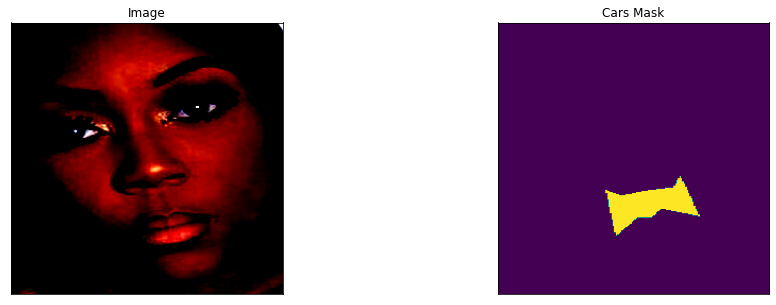

In [ ]:
image, mask = dataset[1] # get some sample
visualize(
    class_num = 1,
    image=image, 
    cars_mask=mask,
)
# print(mask.shape)

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

In [ ]:
ENCODER = 'resnet34'
ENCODER_WEIGHTS = 'imagenet'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=8,
    activation='softmax'
)
model.to(device)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [ ]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

In [ ]:
loss = smp.utils.losses.DiceLoss()

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.99)

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

In [ ]:
# it is a simple loop of iterating over dataloader`s samples
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [ ]:
max_score = 0

for i in range(0, 50):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model.pth')
        print('Model saved!')
        
    if i == 15:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

    if i == 35:
        optimizer.param_groups[0]['lr'] = 1e-7
        print('Decrease decoder learning rate to 1e-7!')


Epoch: 0
train:   0%|          | 0/143 [00:00<?, ?it/s](256, 256, 3)
(256, 256, 8)
train:   1%|          | 1/143 [00:01<04:10,  1.76s/it, dice_loss - 0.9178, iou_score - 0.001095]

/usr/local/lib/python3.6/dist-packages/segmentation_models_pytorch/base/modules.py:89: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


Streaming output truncated to the last 5000 lines.
train:  76%|███████▌  | 108/143 [04:34<01:16,  2.17s/it, dice_loss - 0.2077, iou_score - 0.7685](256, 256, 3)
(256, 256, 8)
train:  76%|███████▌  | 109/143 [04:38<01:26,  2.55s/it, dice_loss - 0.2073, iou_score - 0.7689](256, 256, 3)
(256, 256, 8)
train:  77%|███████▋  | 110/143 [04:41<01:27,  2.64s/it, dice_loss - 0.2066, iou_score - 0.7696](256, 256, 3)
(256, 256, 8)
train:  78%|███████▊  | 111/143 [04:41<01:06,  2.08s/it, dice_loss - 0.2063, iou_score - 0.7699](256, 256, 3)
(256, 256, 8)
train:  78%|███████▊  | 112/143 [04:43<00:56,  1.83s/it, dice_loss - 0.2063, iou_score - 0.7698](256, 256, 3)
(256, 256, 8)
train:  79%|███████▉  | 113/143 [04:45<00:59,  2.00s/it, dice_loss - 0.2059, iou_score - 0.7701](256, 256, 3)
(256, 256, 8)
train:  80%|███████▉  | 114/143 [04:47<00:59,  2.05s/it, dice_loss - 0.2054, iou_score - 0.7708](256, 256, 3)
(256, 256, 8)
train:  80%|████████  | 115/143 [04:49<00:52,  1.88s/it, dice_loss - 0.2049, iou_

In [ ]:
max_score

0.7674008111159005

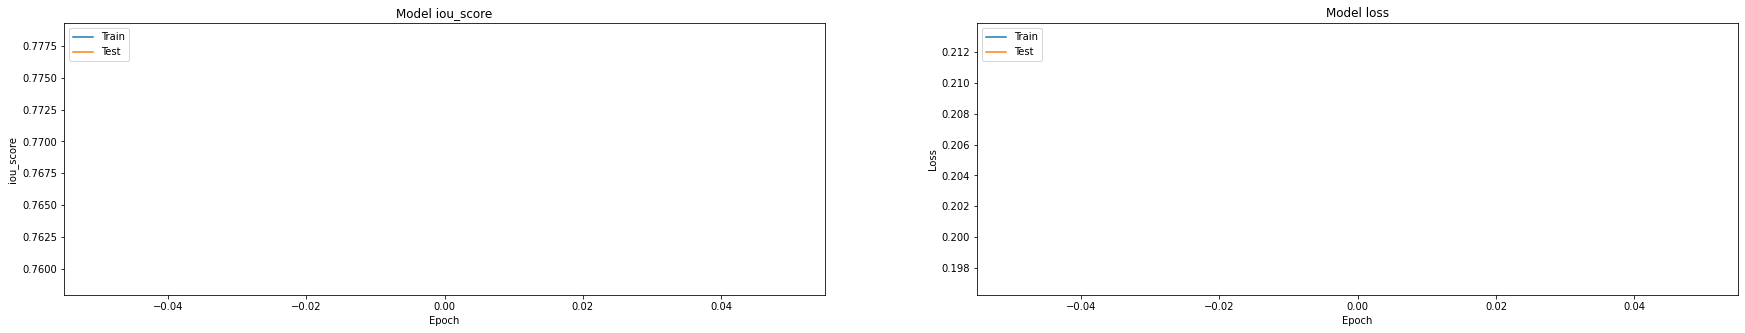

In [ ]:
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(train_logs['iou_score'])
plt.plot(valid_logs['iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(train_logs['dice_loss'])
plt.plot(valid_logs['dice_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
scores = model.evaluate_generator(test_loader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

AttributeError: ignored

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=model,
    loss=loss,
    metrics=metrics,
    device=device,
)

logs = test_epoch.run(test_loader)

valid:   0%|          | 0/18 [00:00<?, ?it/s](256, 256, 3)
(256, 256, 8)
valid:   6%|▌         | 1/18 [00:02<00:47,  2.80s/it, dice_loss - 0.2233, iou_score - 0.7689]

/usr/local/lib/python3.6/dist-packages/segmentation_models_pytorch/base/modules.py:89: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


(256, 256, 3)
(256, 256, 8)
valid:  11%|█         | 2/18 [00:06<00:48,  3.05s/it, dice_loss - 0.2289, iou_score - 0.7531](256, 256, 3)
(256, 256, 8)
valid:  17%|█▋        | 3/18 [00:08<00:39,  2.65s/it, dice_loss - 0.2248, iou_score - 0.765](256, 256, 3)
(256, 256, 8)
valid:  22%|██▏       | 4/18 [00:09<00:32,  2.35s/it, dice_loss - 0.2388, iou_score - 0.7484](256, 256, 3)
(256, 256, 8)
valid:  28%|██▊       | 5/18 [00:14<00:38,  2.99s/it, dice_loss - 0.2314, iou_score - 0.7556](256, 256, 3)
(256, 256, 8)
valid:  33%|███▎      | 6/18 [00:17<00:37,  3.10s/it, dice_loss - 0.2436, iou_score - 0.7442](256, 256, 3)
(256, 256, 8)
valid:  39%|███▉      | 7/18 [00:19<00:29,  2.71s/it, dice_loss - 0.2369, iou_score - 0.7488](256, 256, 3)
(256, 256, 8)
valid:  44%|████▍     | 8/18 [00:21<00:25,  2.55s/it, dice_loss - 0.23, iou_score - 0.7573](256, 256, 3)
(256, 256, 8)
valid:  50%|█████     | 9/18 [00:23<00:22,  2.48s/it, dice_loss - 0.2304, iou_score - 0.753](256, 256, 3)
(256, 256, 8)
valid:  

(256, 256, 3)
(256, 256, 8)
torch.Size([8, 256, 256])


/usr/local/lib/python3.6/dist-packages/segmentation_models_pytorch/base/modules.py:89: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


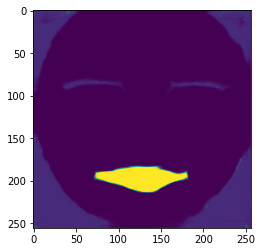

In [ ]:
import torch.nn.functional as F
img, mask = next(iter(test_loader))
img = img.to(device)
output = model(img)

output = output.squeeze() #squeeze выкинуть единичные значения
print(output.shape)
plt.imshow(output.detach().cpu().numpy().transpose(1,2,0)[..., 3])
plt.show()

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir
)

(256, 256, 3)
(256, 256, 8)


/usr/local/lib/python3.6/dist-packages/segmentation_models_pytorch/base/modules.py:89: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


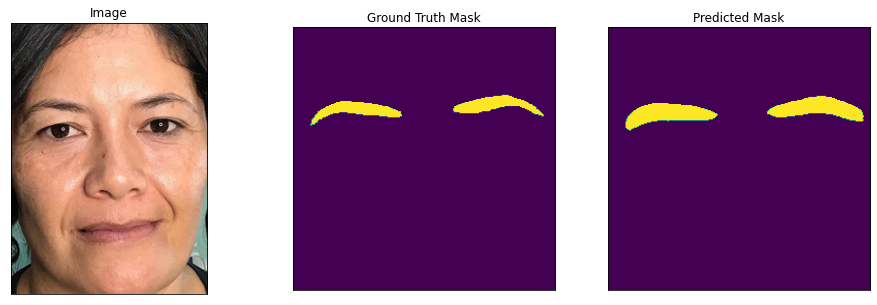

(256, 256, 3)
(256, 256, 8)


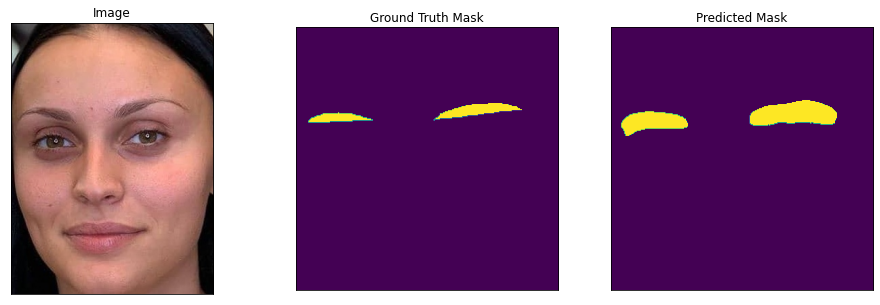

(256, 256, 3)
(256, 256, 8)


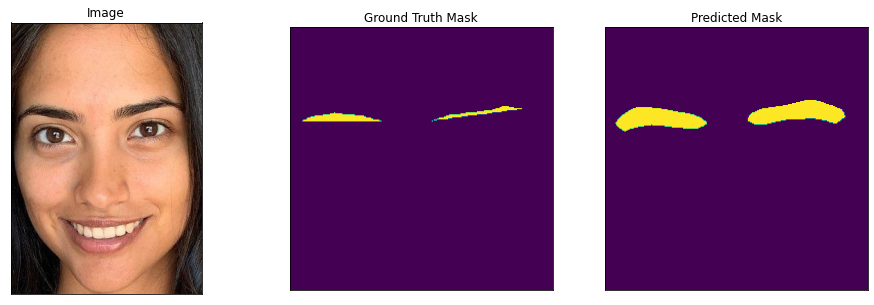

(256, 256, 3)
(256, 256, 8)


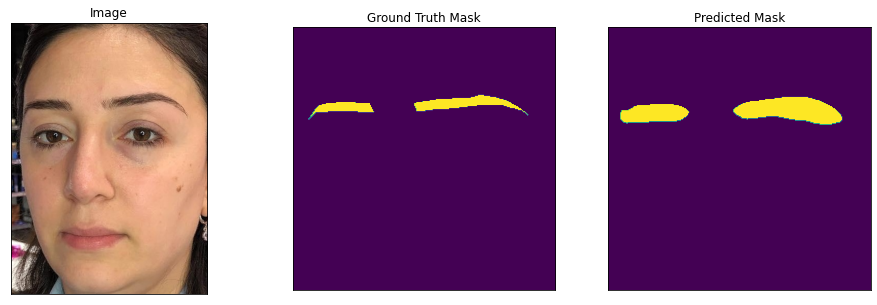

(256, 256, 3)
(256, 256, 8)


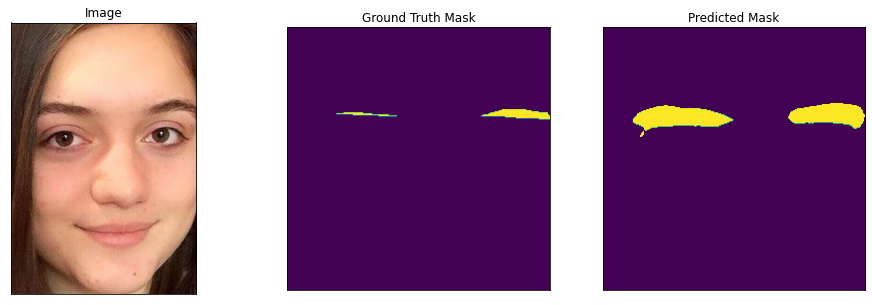

In [ ]:
channel = 3
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze().transpose(1,2,0)
    
    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    mask = model.predict(x_tensor)
    mask = (mask.squeeze().cpu().numpy().round().transpose(1,2,0))
    # print(gt_mask.shape, mask.shape)
    visualize(
        class_num = 4,
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=mask
    )

(256, 256, 3)
(256, 256, 8)


/usr/local/lib/python3.6/dist-packages/segmentation_models_pytorch/base/modules.py:89: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


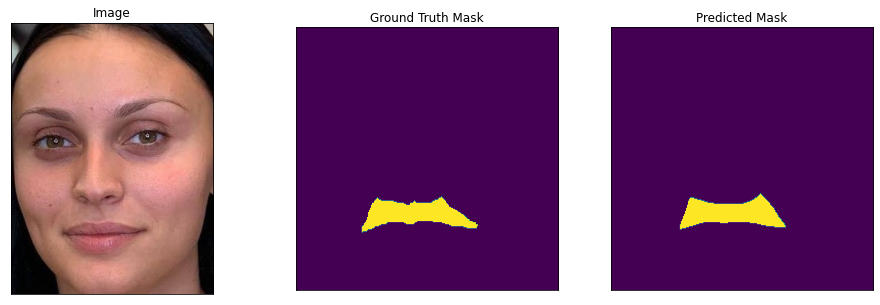

(256, 256, 3)
(256, 256, 8)


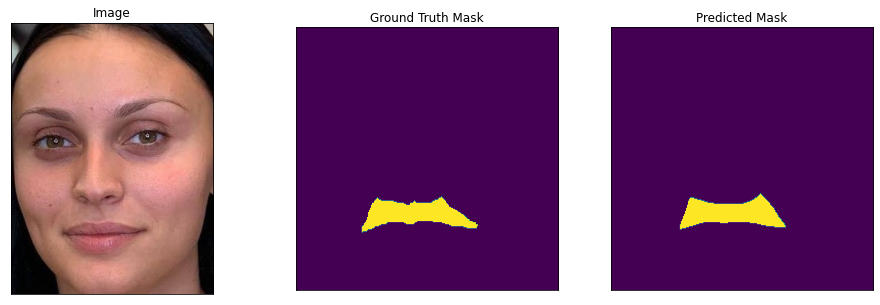

(256, 256, 3)
(256, 256, 8)


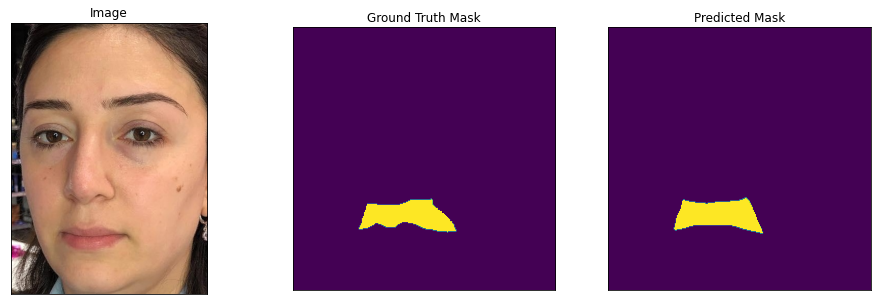

(256, 256, 3)
(256, 256, 8)


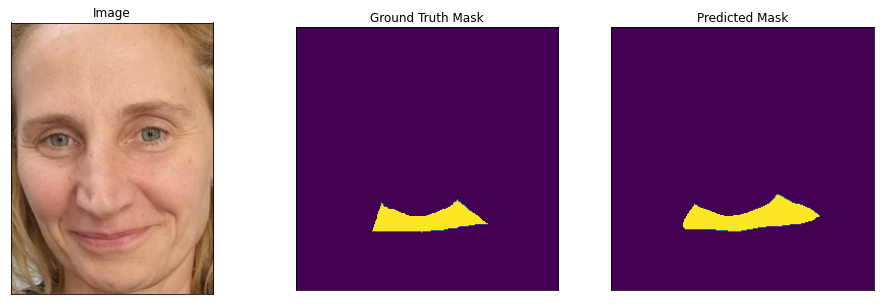

(256, 256, 3)
(256, 256, 8)


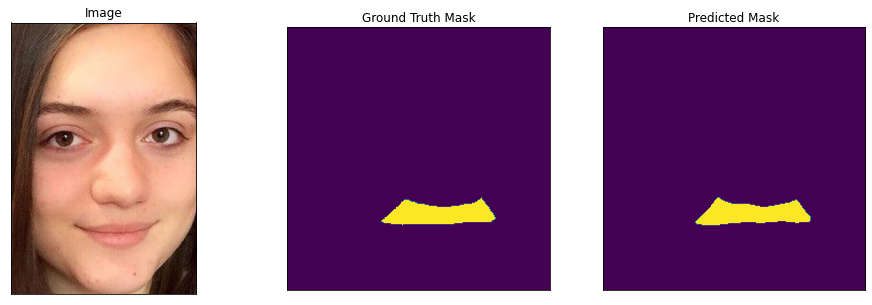

In [ ]:
channel = 3
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze().transpose(1,2,0)
    
    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    mask = model.predict(x_tensor)
    mask = (mask.squeeze().cpu().numpy().round().transpose(1,2,0))
    # print(gt_mask.shape, mask.shape)
    visualize(
        class_num = 1,
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=mask
    )

(256, 256, 3)
(256, 256, 8)


/usr/local/lib/python3.6/dist-packages/segmentation_models_pytorch/base/modules.py:89: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


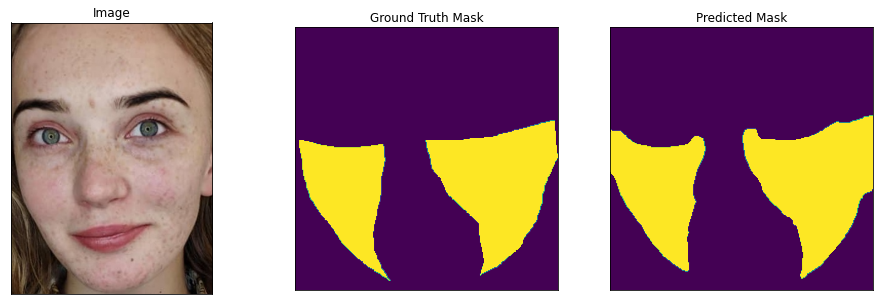

(256, 256, 3)
(256, 256, 8)


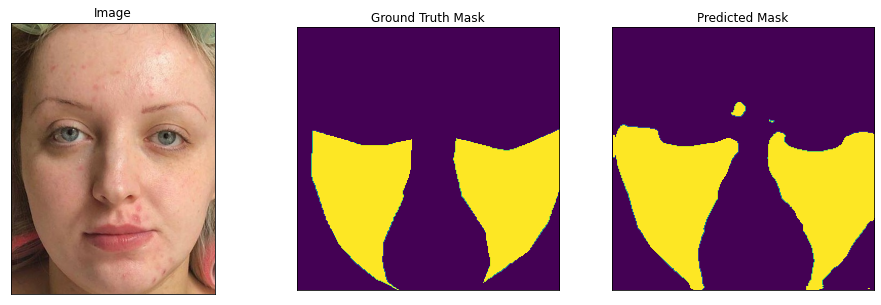

(256, 256, 3)
(256, 256, 8)


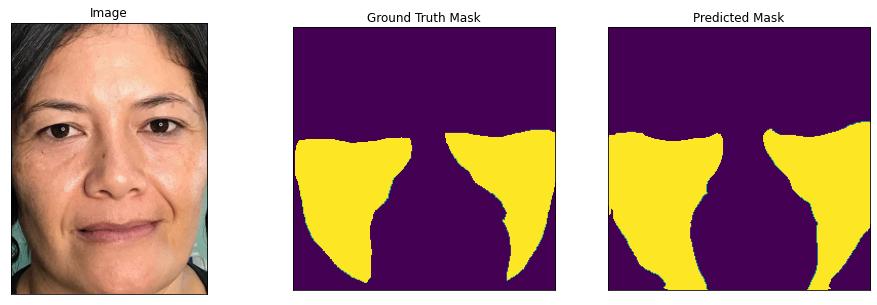

(256, 256, 3)
(256, 256, 8)


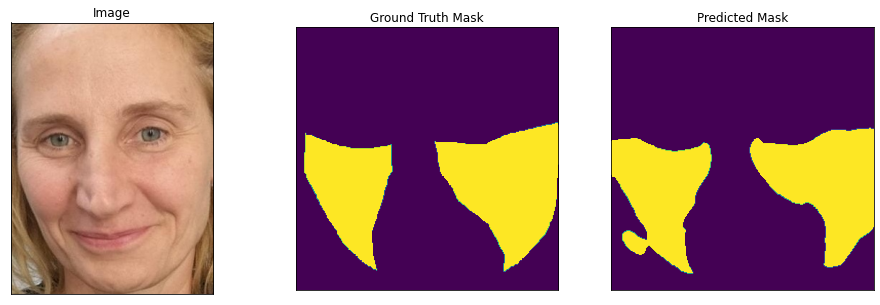

(256, 256, 3)
(256, 256, 8)


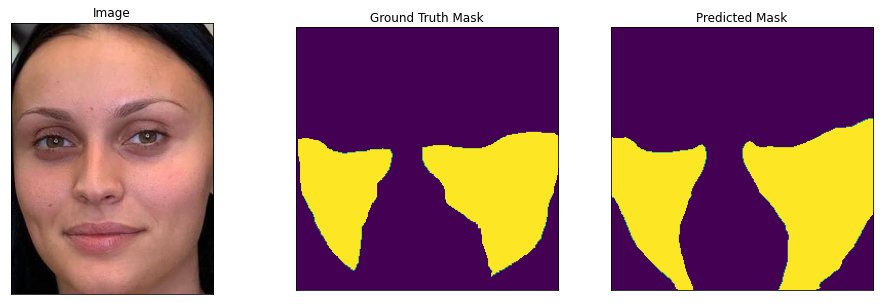

In [ ]:
channel = 3
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze().transpose(1,2,0)
    
    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    mask = model.predict(x_tensor)
    mask = (mask.squeeze().cpu().numpy().round().transpose(1,2,0))
    # print(gt_mask.shape, mask.shape)
    visualize(
        class_num = 2,
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=mask
    )

(256, 256, 3)
(256, 256, 8)


/usr/local/lib/python3.6/dist-packages/segmentation_models_pytorch/base/modules.py:89: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


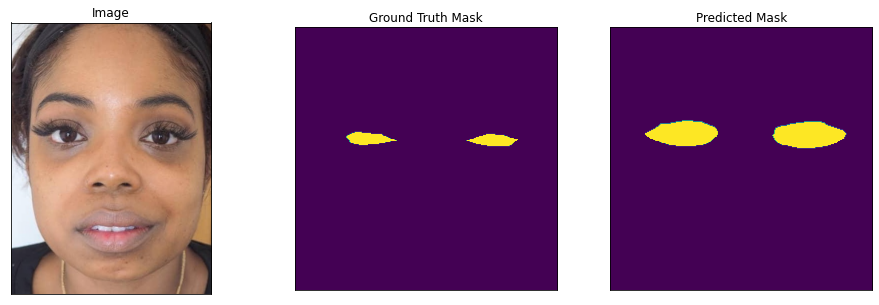

(256, 256, 3)
(256, 256, 8)


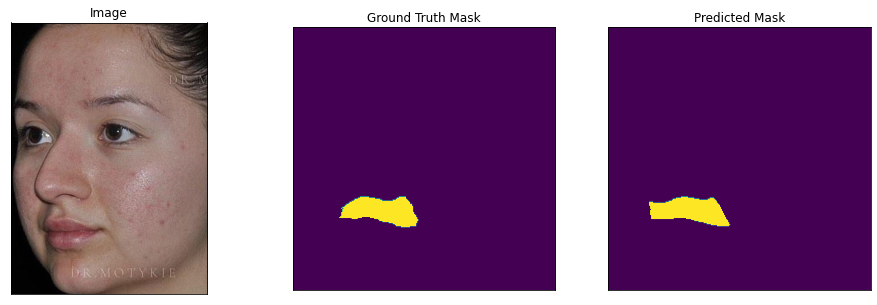

(256, 256, 3)
(256, 256, 8)


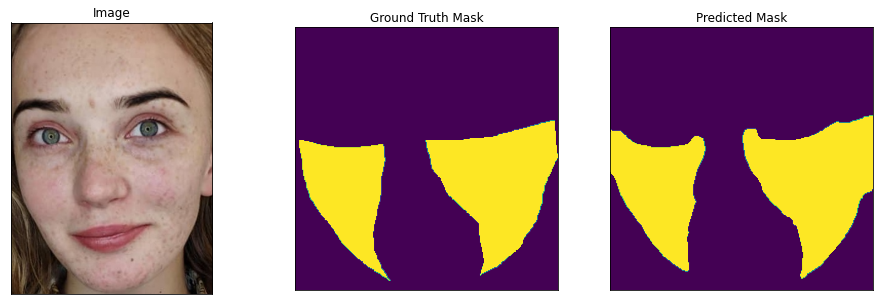

(256, 256, 3)
(256, 256, 8)


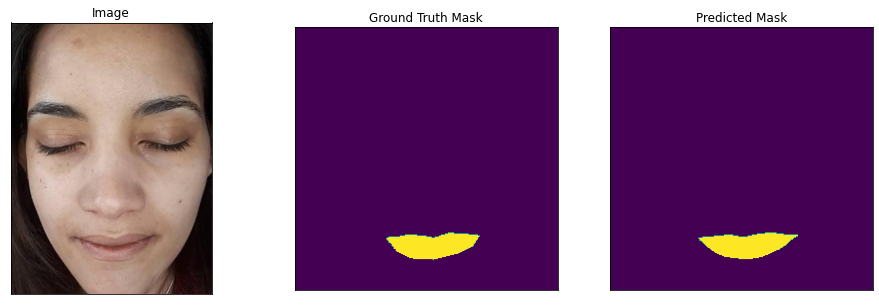

(256, 256, 3)
(256, 256, 8)


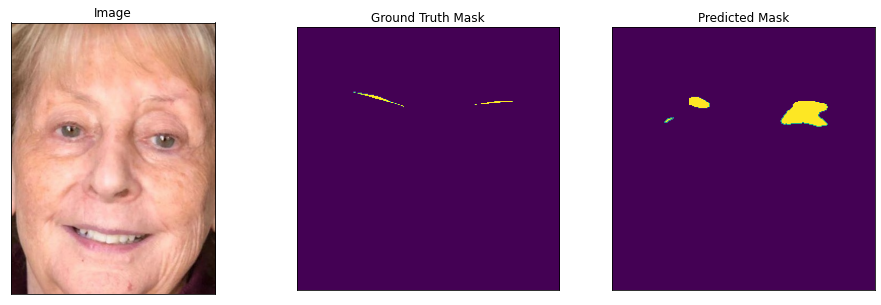

In [ ]:
channel = 3
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze().transpose(1,2,0)
    
    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    mask = model.predict(x_tensor)
    mask = (mask.squeeze().cpu().numpy().round().transpose(1,2,0))
    # print(gt_mask.shape, mask.shape)
    visualize(
        class_num = i,
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=mask
    )

(256, 256, 3)
(256, 256, 8)


/usr/local/lib/python3.6/dist-packages/segmentation_models_pytorch/base/modules.py:89: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)


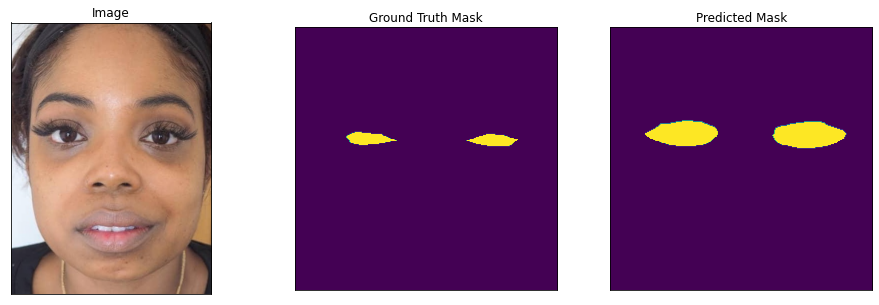

(256, 256, 3)
(256, 256, 8)


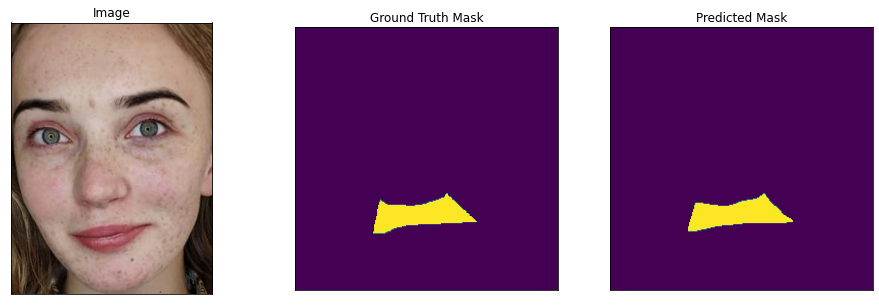

(256, 256, 3)
(256, 256, 8)


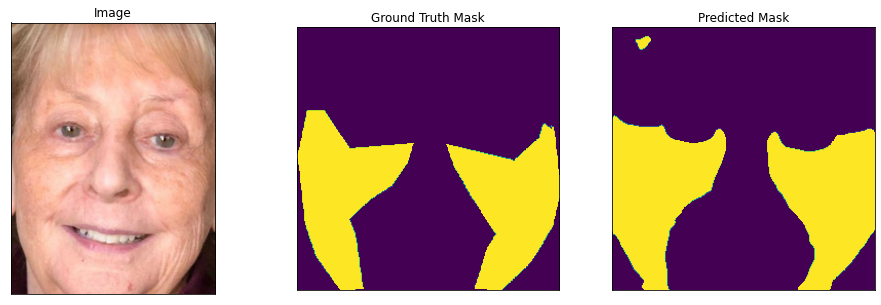

(256, 256, 3)
(256, 256, 8)


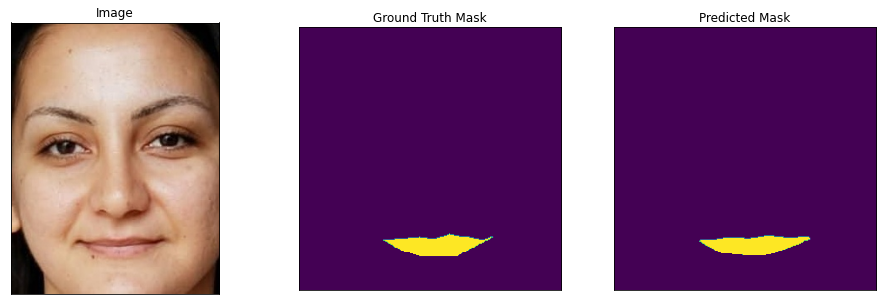

(256, 256, 3)
(256, 256, 8)


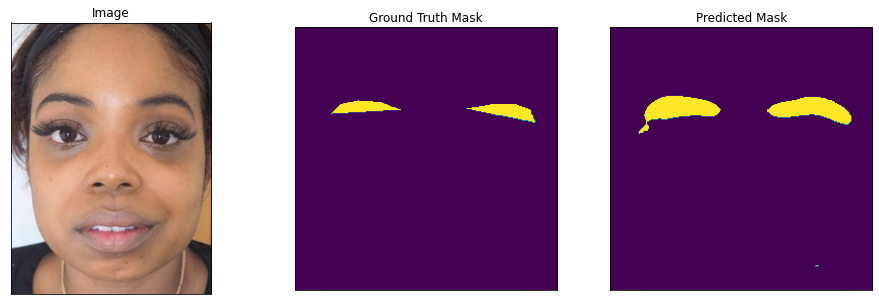

(256, 256, 3)
(256, 256, 8)


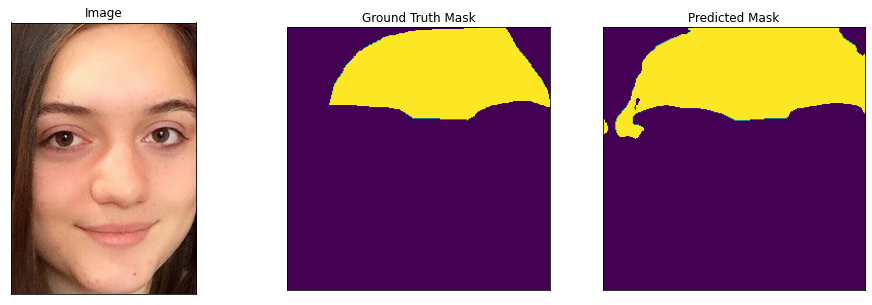

(256, 256, 3)
(256, 256, 8)


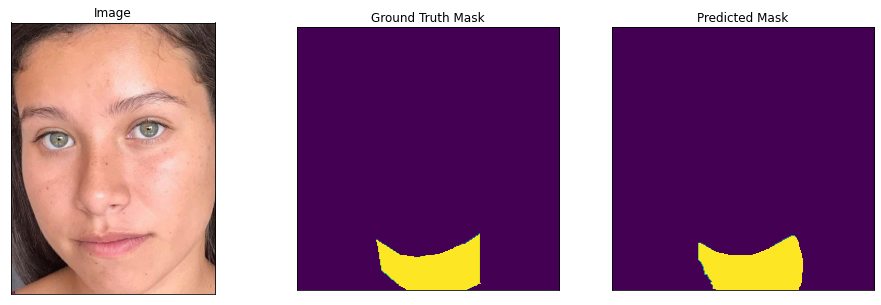

(256, 256, 3)
(256, 256, 8)


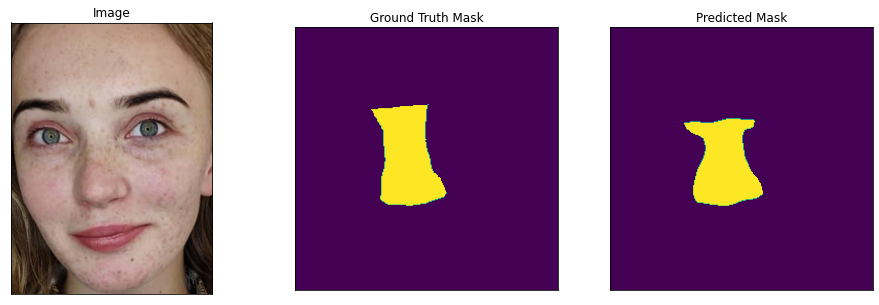

In [ ]:
channel = 3
for i in range(8):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze().transpose(1,2,0)
    
    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)
    mask = model.predict(x_tensor)
    mask = (mask.squeeze().cpu().numpy().round().transpose(1,2,0))
    # print(gt_mask.shape, mask.shape)
    visualize(
        class_num = i,
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=mask
    )